# Hazard Extraction
There are multiple levels of clustering:
1. hazard present vs. hazard not present
2. within hazards, there are general systems in which these occur
3. within each system, there are specific hazards that occur

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import tomotopy as tp
import sys
import os

In [2]:
sys.path.append(os.path.join('..'))
from module.topic_model_plus_class import Topic_Model_plus

### Known Hazards:


In [3]:
subsystems = ["Avionics", "Aircraft Type", "Performance Standards", "Contracting", "Fuel",
             "Mission", "Airspace", "Communication"]
total_hazards = {
    "Avionics": ["avionics failure", "avionics package insufficient for mission complexity", "contract pilot unfamiliar with avionics"],
    "Aircraft Type":["reduced field of view for the flight crew"], 
    "Performance Standards": ["poor engine performance"], 
    "Contracting":["contract pilot skill/fire experience leading to substandard performance"], 
    "Fuel":["capacity, prodcedure, groundfueling errors"],
    "Mission":["restricted visibility", "wake turbulence", "weather", "poor fuel management", "controlled flight into terrain due to low-level ops",
              "collision potential / close proximity to other aircraft", "overly reliant on technology", "aircraft emergency",
              "exceeded span of control", "unclear objectives/tasks", "ATGS performance results in hazardous operations",
              "unnecessary exposure due to inefficient operational use of tactical aircraft", "aircraft operating without aerial supervison",], 
    "Airspace":["Aircraft not complying with FTA procedures", "multiple IA incidents in same area cause confusion",
               "special use airspace, aircraft not coordinating with controlling agency", "non-incident aircraft intrusion in TFR",
               "fires in proximity of airport/strip, potential for MAC"], 
    "Communication":["radio frequency congestion", "resources on different bandwidth", "hazardous air operations due to inaccurate information in dispatch system"]
}

general_systems = len(subsystems)
per_subsystem = [len(total_hazards[subsystem]) for subsystem in total_hazards]
total_specific = sum(per_subsystem)
print(general_systems, total_specific)
print(per_subsystem)


8 28
[3, 1, 1, 1, 1, 13, 5, 3]


## Prepare Data

In [5]:
#data_file = r"C:\Users\srandrad\smart_nlp\input data\ICS_filtered_preprocessed_combined.csv"
#list_of_attributes = ["Combined Text"]
list_of_attributes = ["REMARKS", "SIGNIF_EVENTS_SUMMARY", "MAJOR_PROBLEMS"]
document_id_col = "INCIDENT_ID"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
name = os.path.join('..','data','ICS_clustering_tests')
file_name = os.path.join('..','data','209-PLUS','ics209-plus-wildfire','ics209-plus-wildfire','ics209-plus-wf_sitreps_1999to2014.csv')
data_ICS = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, csv_file=file_name, list_of_attributes=list_of_attributes, database_name=name, combine_cols=True)
data_ICS.prepare_data(dtype=str)
#data_ICS.ngrams = "custom"
#data_ICS.extract_preprocessed_data(data_file)
data = data_ICS.data_df

Combining Columns…: 100%|████████████████████████████████████████████████████| 120804/120804 [01:46<00:00, 1136.11it/s]


data preparation:  1.831808042526245 minutes 



In [6]:
file = os.path.join('..','data','ICS_filtered_preprocessed_combined_data.csv')
filtered_df = pd.read_csv(file)
filtered_ids = filtered_df['INCIDENT_ID'].unique()
data_ICS.data_df = data_ICS.data_df.loc[data_ICS.data_df["INCIDENT_ID"].isin(filtered_ids)].reset_index(drop=True) 
data = data_ICS.data_df
data_ids = data["INCIDENT_ID"].unique()
print(len(filtered_ids), len(data_ids))
data 


8991 8991


,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text
0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.0,230.0,197,196,resources are being shared between this fire a...
1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.0,230.0,197,196,resources have been shared between the saddle ...
2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.0,165.0,197,196,resources are being shared between the saddle ...
3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.333333333333333,192.3333333333333,197,196,resources are being shared between the skinner...
4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333333333333,192.3333333333333,197,196,resources are being shared between the skinner...
...,...,...,...,...,...,...,...,...,...,...
58725,2014,2014-03-19 14:00:00,2014_VAVAS1406037_AIRPORT MOUNTAIN,85.0,2014.0,0.0,18.5,80,78,heavy plume grass is the primary carrier of th...
58726,2014,2014-03-19 14:00:00,2014_VAVAS1406037_AIRPORT MOUNTAIN,100.0,2014.0,0.0,18.5,82,78,controlled
58727,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.0,95.0,234,232,heavy fire in canyons which lead to the columb...
58728,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.0,120.0,235,232,fire laid down over night with testing from wi...


In [7]:
print(type(data.iloc[0]["Combined Text"]))

<class 'str'>


In [8]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english', min_df=5)
X = vectorizer.fit_transform(data["Combined Text"])

## Level 1 Clustering

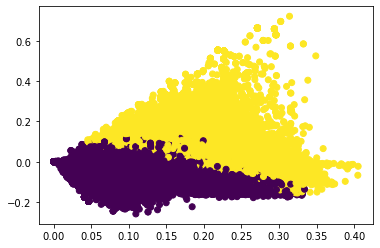

In [9]:
kmeans = KMeans(n_clusters=2, random_state=33)
kmeans.fit(X)
predictions = kmeans.predict(X)

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show()        

## Level 2 Clustering

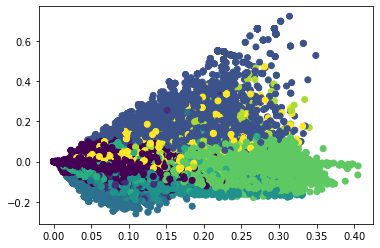

In [10]:
kmeans = KMeans(n_clusters=9, random_state=33)
kmeans.fit(X)
predictions = kmeans.predict(X)

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show() 

## Level 3 Clustering

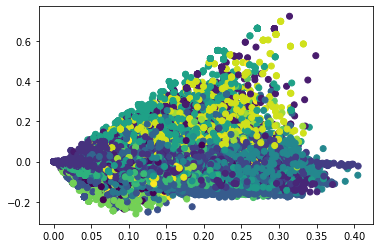

In [11]:
kmeans = KMeans(n_clusters=29, random_state=33)
kmeans.fit(X)
predictions = kmeans.predict(X)

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show() 

## Experimental

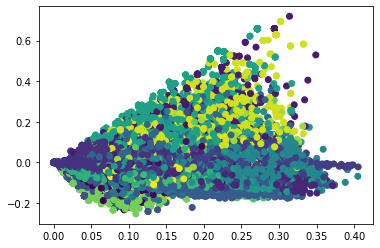

Estimated number of clusters: 256
Estimated number of noise points: 53433
Silhouette Coefficient: -0.215


In [12]:
db = DBSCAN(eps=0.600, min_samples=10, p=np.shape(X)[1], metric = 'l2').fit(X)
labels = db.labels_
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show() 

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

In [13]:
np.shape(X)[1]

12619

#### HDP

In [21]:
data_file = os.path.join('..','data','ICS_filtered_preprocessed_combined_data.csv')
list_of_attributes = ["Combined Text"]
document_id_col = "INCIDENT_ID"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
name = os.path.join('..','data','HDP_tests')
data_ICS = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, name=name, combine_cols=True)
data_ICS.ngrams = "custom"
data_ICS.extract_preprocessed_data(data_file)
data = data_ICS.data_df
data

/Users/hswalsh/Library/Python/3.7/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Preprocessed data extracted from:  ../data/ICS_filtered_preprocessed_combined_data.csv


,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text,Unique IDs
0,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010,5.000000,230.000000,197,196,"[resource, share, cactus]",2000_CA-RRU-062485_VALLEY COMPLEX_0
1,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010,5.000000,230.000000,197,196,"[resource, share, incident, cactus, incident, ...",2000_CA-RRU-062485_VALLEY COMPLEX_1
2,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010,4.000000,165.000000,197,196,"[resource, share, cactus, erratic, wind, due, ...",2000_CA-RRU-062485_VALLEY COMPLEX_2
3,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010,4.333333,192.333333,197,196,"[resource, share, cactus, cactus, become, vall...",2000_CA-RRU-062485_VALLEY COMPLEX_4
4,2010,7/15/2010 15:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010,4.333333,192.333333,197,196,"[resource, share, cactus, cactus, become, vall...",2000_CA-RRU-062485_VALLEY COMPLEX_5
...,...,...,...,...,...,...,...,...,...,...,...
44358,2014,3/15/2014 14:30,2014_VAVAS1403037_BEAVER LODGE RD.,100.0,2014,0.000000,13.000000,74,74,"[fast, spread, field]",2014_VAVAS1403037_BEAVER LODGE RD._0
44359,2014,3/19/2014 14:00,2014_VAVAS1406037_AIRPORT MOUNTAIN,85.0,2014,0.000000,18.500000,80,78,"[heavy, plume, primary, carrier]",2014_VAVAS1406037_AIRPORT MOUNTAIN_1
44360,2014,8/20/2014 13:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014,1.000000,95.000000,234,232,"[heavy, canyon, river, mainly, canyon, come, e...",2014_WA-WFS-513_SAND RIDGE_0
44361,2014,8/20/2014 13:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014,1.000000,120.000000,235,232,"[laid, night, test, wind, remain, canyon, peri...",2014_WA-WFS-513_SAND RIDGE_1


In [22]:
mdl = tp.HDPModel(tw = tp.TermWeight.IDF)
texts = data["Combined Text"].tolist()
for text in texts:
    mdl.add_doc(text)
for i in range(0, 1000, 10):
    mdl.train(10)
results = {}
results["topic number"]=[]
results["number of words"]=[]
results["topic words"]=[]
#coh = tp.coherence.Coherence(mdl, coherence= "c_v")
#results["coherence per topic"] = [coh.get_score(topic_id=k) for k in range(mdl.k) if (mdl.is_live_topic(k))]
for k in range(mdl.k):
    if not mdl.is_live_topic(k):
        continue
    #results["number of documents in topic"].append(mdl.num_docs_of_topic(k))
    results["topic number"].append(k)
    results["number of words"].append(mdl.get_count_by_topics()[k])
    results["topic words"].append(", ".join([word[0] for word in mdl.get_topic_words(k, top_n=mdl.get_count_by_topics()[k])]))

/Users/hswalsh/Library/Python/3.7/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
results_df = pd.DataFrame(results)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
print(mdl.k)

48


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
new_lda_model, new_topic_id = mdl.convert_to_lda(topic_threshold=0.05)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
new_lda_model.save("HDP_to_LDA.bin")

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
results_df

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic number,number of words,topic words
0,0,215481,"concern, continue, impact, closure, forest, in..."
1,1,246131,"continue, threaten, creek, resource, community..."
2,2,2420,"violation, possible violation, value possible ..."
3,3,31301,"unexploded, ordinance, unexploded ordinance, e..."
4,4,102760,"structure, closure, public, evacuation, privat..."
5,5,20145,"smokejumper, crew, secure, demote, continued, ..."
6,6,109,"riparian, core, methodius, lanx, eared, nail, ..."
7,7,203,"april, fill, acre, lark, complex, sister, roan..."
8,8,112,"final submit, submit, habitate, final, call, d..."
9,9,126,"grazing permit, loss forage, grazing, forage, ..."


# Clustering hLDA results
this will be examined in two ways:
1. clustering individual topics 
2. clustering individual words within topics

In [53]:
hlda_combined_df = pd.read_excel(os.path.join('..','results','ICS_full_combined_topics-May-17-2021','hlda_results.xlsx'), sheet_name = ["Combined Text"])
hlda_combined_df['Combined Text']

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic level,topic number,parent,number of documents in topic,topic words,number of words,best document,coherence
0,0,0,-1,53254,"terrain, crew, resource, steep, today, access,...",455242,2012_CA-MDF-521_ANTELOPE,0.743148
1,1,8,0,6570,"terrain, steep, direct, support, safety, opera...",55891,2013_CO-SJF-000285_WEST FORK COMPLEX,0.758589
2,1,9,0,2682,"loss, forage, concern, loss forage, creek, gra...",18404,2006_WA-SPS-062_CARBON COPY COMPLEX,0.785130
3,1,10,0,3722,"strategy, helicopter, action, access, need, cr...",31999,2006_CA-KNF-003497_UNCLES COMPLEX,0.750550
4,1,11,0,4392,"remains, evacuation, close, unified command, r...",33037,2007_CA-LPF-001087_ZACA TWO,0.756841
...,...,...,...,...,...,...,...,...
171,2,181,166,16,"noel, verdin, precipice, recipe, front passing...",7,2008_OK-OSA-008032_MEXICO PASTURE,0.774041
172,1,184,0,38,"perception, event occurs, yamaha, thee, poet, ...",76,2008_FL-FLS-2008-17-0126_CAYO FIRE,0.949297
173,1,185,0,19,"firenze, curtis, afford, fast, thieve, unfamil...",55,2011_NE-NES-110289_MOTHERS DAY,0.949716
174,1,186,0,13,"oceanside, penile, base oceanside, neil, contr...",74,2011_CA-RRU-77036_GARZA,0.942975


### 1. Clustering individual topics
topics are put into two clusters (hazard relevant, not hazard relevant) based on the tfidf of their topic words

In [15]:
#X = [str(text).split(", ") for text in hlda_combined_df['Combined Text']['topic words'].tolist()]
X = hlda_combined_df['Combined Text']['topic words'].astype(str)
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english', min_df=5)
X_vec = vectorizer.fit_transform(X)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


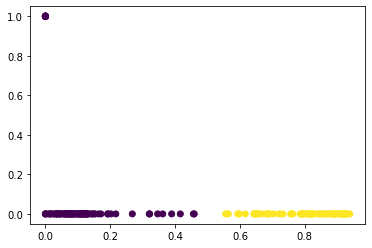

In [16]:
kmeans = KMeans(n_clusters=2, random_state=33)
kmeans.fit(X_vec)
predictions = kmeans.predict(X_vec)

pca = TruncatedSVD(n_components=2).fit(X_vec)
data2D = pca.transform(X_vec)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show()

In [17]:
hlda_combined_df['Combined Text']['topic classification'] = predictions

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
hlda_combined_df['Combined Text']

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic level,topic number,parent,number of documents in topic,topic words,number of words,best document,coherence,topic classification
0,0,0,-1,53254,"terrain, crew, resource, steep, today, access,...",455242,2012_CA-MDF-521_ANTELOPE,0.743148,1
1,1,8,0,6570,"terrain, steep, direct, support, safety, opera...",55891,2013_CO-SJF-000285_WEST FORK COMPLEX,0.758589,1
2,1,9,0,2682,"loss, forage, concern, loss forage, creek, gra...",18404,2006_WA-SPS-062_CARBON COPY COMPLEX,0.785130,1
3,1,10,0,3722,"strategy, helicopter, action, access, need, cr...",31999,2006_CA-KNF-003497_UNCLES COMPLEX,0.750550,1
4,1,11,0,4392,"remains, evacuation, close, unified command, r...",33037,2007_CA-LPF-001087_ZACA TWO,0.756841,1
...,...,...,...,...,...,...,...,...,...
171,2,181,166,16,"noel, verdin, precipice, recipe, front passing...",7,2008_OK-OSA-008032_MEXICO PASTURE,0.774041,0
172,1,184,0,38,"perception, event occurs, yamaha, thee, poet, ...",76,2008_FL-FLS-2008-17-0126_CAYO FIRE,0.949297,0
173,1,185,0,19,"firenze, curtis, afford, fast, thieve, unfamil...",55,2011_NE-NES-110289_MOTHERS DAY,0.949716,0
174,1,186,0,13,"oceanside, penile, base oceanside, neil, contr...",74,2011_CA-RRU-77036_GARZA,0.942975,0


In [23]:
for i in range(len(hlda_combined_df['Combined Text'])):
    if pd.isna(hlda_combined_df['Combined Text'].iloc[i]['topic words']):
        print(hlda_combined_df['Combined Text'].iloc[i]['topic classification'])

0
0
0
0
0
0
0
0
0
0
0


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
useable_df = hlda_combined_df['Combined Text'].loc[hlda_combined_df['Combined Text']['topic classification']==1].reset_index(drop=True)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
useable_df

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic level,topic number,parent,number of documents in topic,topic words,number of words,best document,coherence,topic classification
0,0,0,-1,53254,"terrain, crew, resource, steep, today, access,...",455242,2012_CA-MDF-521_ANTELOPE,0.743148,1
1,1,8,0,6570,"terrain, steep, direct, support, safety, opera...",55891,2013_CO-SJF-000285_WEST FORK COMPLEX,0.758589,1
2,1,9,0,2682,"loss, forage, concern, loss forage, creek, gra...",18404,2006_WA-SPS-062_CARBON COPY COMPLEX,0.785130,1
3,1,10,0,3722,"strategy, helicopter, action, access, need, cr...",31999,2006_CA-KNF-003497_UNCLES COMPLEX,0.750550,1
4,1,11,0,4392,"remains, evacuation, close, unified command, r...",33037,2007_CA-LPF-001087_ZACA TWO,0.756841,1
...,...,...,...,...,...,...,...,...,...
72,2,122,10,363,"urban interface, urban, interface, moth, gypsy...",1433,2006_VA-VAF-060028_QUARRY,0.880052,1
73,2,124,114,1210,"stage, barker, whip, maximum manageable, maxim...",1862,2008_ID-STF-000294_SOUTH BARKER,0.926049,1
74,2,130,8,54,"create environment, create environment unsafe,...",1418,2013_CO-SJF-000285_WEST FORK COMPLEX,0.972821,1
75,1,146,0,175,"specie, endanger, threaten endanger, specie ha...",2398,2012_CA-ANF-004803_WILLIAMS,0.917328,1


In [29]:
un_useable_df = hlda_combined_df['Combined Text'].loc[hlda_combined_df['Combined Text']['topic classification']==0].reset_index(drop=True)
un_useable_df

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic level,topic number,parent,number of documents in topic,topic words,number of words,best document,coherence,topic classification
0,1,47,0,174,"cliff, cliff band, band, close proximity, clif...",772,2012_WA-OWF-000559_WENATCHEE COMPLEX,0.837838,0
1,2,51,42,253,"insect disease, disease, insect, insect diseas...",827,2009_CA-YNP-1659_HARDEN,0.923365,0
2,2,57,14,142,"towards hoop valley, hoop, hoop valley, ahead,...",673,2013_CA-SRF-1486_CORRAL COMPLEX,0.907578,0
3,2,60,15,53,"class, cabinet class, cabinet class wish, cabi...",275,2006_MT-KNF-000233_ROSS COMPLEX,0.941831,0
4,2,65,12,81,"street, confines bottom, confines, avenue, kil...",315,2014_014268_HAYSTACK COMPLEX (7 FIRES),0.950601,0
...,...,...,...,...,...,...,...,...,...
94,2,181,166,16,"noel, verdin, precipice, recipe, front passing...",7,2008_OK-OSA-008032_MEXICO PASTURE,0.774041,0
95,1,184,0,38,"perception, event occurs, yamaha, thee, poet, ...",76,2008_FL-FLS-2008-17-0126_CAYO FIRE,0.949297,0
96,1,185,0,19,"firenze, curtis, afford, fast, thieve, unfamil...",55,2011_NE-NES-110289_MOTHERS DAY,0.949716,0
97,1,186,0,13,"oceanside, penile, base oceanside, neil, contr...",74,2011_CA-RRU-77036_GARZA,0.942975,0


Conclusion: topics marked with label 1 are possibly useable but they seem to have more words per topic

### 2. Clustering individual words within topics
words are put into clusters of useful or not useful to remove unnecessary words from all topics

In [47]:
X = [word for text in hlda_combined_df['Combined Text']['topic words'].tolist() for word in str(text).split(", ")]
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,stop_words='english', min_df=5)
X_vec = vectorizer.fit_transform(X)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


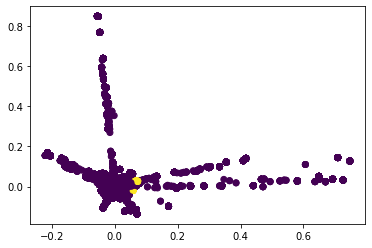

In [48]:
kmeans = KMeans(n_clusters=2, random_state=33)
kmeans.fit(X_vec)
predictions = kmeans.predict(X_vec)

pca = TruncatedSVD(n_components=2).fit(X_vec)
data2D = pca.transform(X_vec)
plt.scatter(data2D[:,0], data2D[:,1], c=predictions)
plt.show()

In [49]:
class_dict = {X[i]: predictions[i] for i in range(len(predictions))}
class_dict

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'terrain': 0,
 'crew': 0,
 'resource': 0,
 'steep': 0,
 'today': 0,
 'access': 0,
 'make': 0,
 'type': 0,
 'fuel': 0,
 'progress': 0,
 'continue': 0,
 'heavy': 0,
 'containment': 0,
 'weather': 0,
 'structure': 0,
 'team': 0,
 'complete': 0,
 'incident': 0,
 'spot': 0,
 'operation': 0,
 'perimeter': 0,
 'continued': 0,
 'evacuation': 0,
 'limited': 0,
 'concern': 0,
 'helicopter': 0,
 'work': 0,
 'difficult': 0,
 'acre': 0,
 'condition': 0,
 'behavior': 0,
 'closure': 0,
 'good': 0,
 'increase': 0,
 'smoke': 0,
 'local': 0,
 'division': 0,
 'close': 0,
 'construction': 0,
 'significant': 0,
 'potential': 0,
 'transition': 0,
 'need': 0,
 'dozer': 0,
 'creek': 0,
 'flank': 0,
 'command': 1,
 'good progress': 0,
 'start': 0,
 'support': 0,
 'burning': 0,
 'suppression': 0,
 'effort': 0,
 'burnout': 0,
 'extreme': 0,
 'plan': 0,
 'impact': 0,
 'contain': 0,
 'activity': 0,
 'engine': 0,
 'protection': 0,
 'spread': 0,
 'threaten': 0,
 'begin': 0,
 'rugged': 0,
 'safety': 0,
 'expect': 0,

In [54]:
topic_words_filtered_1 = []
num_words_1 = []
topic_words_filtered_0 = []
num_words_0 = []
for i in range(len(hlda_combined_df['Combined Text'])):
    words = str(hlda_combined_df['Combined Text'].iloc[i]["topic words"]).split(", ")
    new_words1 = []
    new_words0 = []
    for word in words:
        if class_dict[word] == 1:
            new_words1.append(word)
        elif class_dict[word] == 0:
            new_words0.append(word)
    topic_words_filtered_1.append(new_words1)
    num_words_1.append(len(new_words1))
    topic_words_filtered_0.append(new_words0)
    num_words_0.append(len(new_words0))
topics_df_0 = hlda_combined_df['Combined Text'].copy()
topics_df_0['topic words'] = topic_words_filtered_0
topics_df_0['number of words'] = num_words_0
topics_df_1 = hlda_combined_df['Combined Text'].copy()
topics_df_1['topic words'] = topic_words_filtered_1 
topics_df_1['number of words'] = num_words_1

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
topics_df_1

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic level,topic number,parent,number of documents in topic,topic words,number of words,best document,coherence
0,0,0,-1,53254,"[command, assume command, transfer command, un...",7,2012_CA-MDF-521_ANTELOPE,0.743148
1,1,8,0,6570,"[command, assume command, unified, transfer co...",7,2013_CO-SJF-000285_WEST FORK COMPLEX,0.758589
2,1,9,0,2682,"[command, transfer command, assume command, un...",8,2006_WA-SPS-062_CARBON COPY COMPLEX,0.785130
3,1,10,0,3722,"[command, transfer command, assume command, un...",8,2006_CA-KNF-003497_UNCLES COMPLEX,0.750550
4,1,11,0,4392,"[unified command, unified, command, assume com...",15,2007_CA-LPF-001087_ZACA TWO,0.756841
...,...,...,...,...,...,...,...,...
171,2,181,166,16,[],0,2008_OK-OSA-008032_MEXICO PASTURE,0.774041
172,1,184,0,38,[],0,2008_FL-FLS-2008-17-0126_CAYO FIRE,0.949297
173,1,185,0,19,[],0,2011_NE-NES-110289_MOTHERS DAY,0.949716
174,1,186,0,13,[],0,2011_CA-RRU-77036_GARZA,0.942975


In [56]:
topics_df_0

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic level,topic number,parent,number of documents in topic,topic words,number of words,best document,coherence
0,0,0,-1,53254,"[terrain, crew, resource, steep, today, access...",3078,2012_CA-MDF-521_ANTELOPE,0.743148
1,1,8,0,6570,"[terrain, steep, direct, support, safety, oper...",2759,2013_CO-SJF-000285_WEST FORK COMPLEX,0.758589
2,1,9,0,2682,"[loss, forage, concern, loss forage, creek, gr...",2795,2006_WA-SPS-062_CARBON COPY COMPLEX,0.785130
3,1,10,0,3722,"[strategy, helicopter, action, access, need, c...",2835,2006_CA-KNF-003497_UNCLES COMPLEX,0.750550
4,1,11,0,4392,"[remains, evacuation, close, resident, steep, ...",2791,2007_CA-LPF-001087_ZACA TWO,0.756841
...,...,...,...,...,...,...,...,...
171,2,181,166,16,"[noel, verdin, precipice, recipe, front passin...",7,2008_OK-OSA-008032_MEXICO PASTURE,0.774041
172,1,184,0,38,"[perception, event occurs, yamaha, thee, poet,...",76,2008_FL-FLS-2008-17-0126_CAYO FIRE,0.949297
173,1,185,0,19,"[firenze, curtis, afford, fast, thieve, unfami...",55,2011_NE-NES-110289_MOTHERS DAY,0.949716
174,1,186,0,13,"[oceanside, penile, base oceanside, neil, cont...",74,2011_CA-RRU-77036_GARZA,0.942975
